# *How to Tweet Like Magic Johnson*

by Akshath Rajaram

---
   
   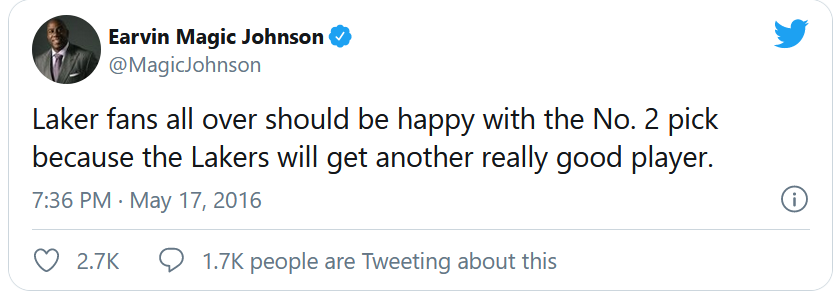
   
   
   
   NBA legend Magic Johnson's impact on the game has been unprecedented, becoming one of the league's best point guards and controlling the game with his mythical passing ability. After his storied playing career of five championships and three MVP awards, Magic went on to affect change with his advocacy for HIV/AIDS awareness, as well his work as an executive with the Lakers. These accomplishments, however, all pale in comparison to his greatest contribution of all: [his Twitter account](https://twitter.com/MagicJohnson?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor). 
   
   What we are aiming to do is build a language model that generates tweets in the style of Magic Johnson. To do this, we're going to use the FastAI package and the One-Cycle algorithm, which should create a model that is able to predict words in a typical sentence formation. To train our model, we're going to use a dataset of 3100 tweets from Magic Johnson, dating from 2021 to 2019. To create this dataset, we're going to use the TwitterAPI, which restricts users from collecting more than 3100 tweets. 
   
   Once we have a model that generates tweets, we want to build a Twitter bot that will output these tweets periodically as status updates ##FINISH AFTER BOT
  
  
   




## Packages and Libraries

To use the TwitterAPI and model our data, we have to import a couple of important libraries that can help us out: 

- The [os](https://docs.python.org/3/library/os.html) package gives us a collection of OS interfaces that we can use internally during development
- The [tweepy](http://docs.tweepy.org/en/latest/) package helps us use the TwitterAPI to find our tweets and build out our dataset
- [Pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) is a standard data analysis library that helps us pre-process that data and perform other operations. 
- [FastAI](https://docs.fast.ai/) is a library that will help us do multiple text processing operations as well as help us to build out our model. 
- [csv](https://docs.python.org/3/library/csv.html) is a package we'll use to write the tweets to a csv file.


In [98]:
import os #collection of operating system interfaces
import tweepy as tw #library for TwitterAPI
import pandas as pd #data analysis package
from fastai.text import *
from pandas import DataFrame
import unicodecsv as csv#csv package
from collections import Counter
import random

## TwitterAPI Setup

To get access to Magic's tweets, we have to sign up for permissions to access the [Twitter API](https://developer.twitter.com/en/docs/twitter-api/getting-started/guide). After following the "Getting Started" guide outlined in the link above, you'll have what's called an "App", which is just a proxy for using/making requests with the API. Once we have our App, we're going to obtain four things: 

- A consumer key and secret consumer key: think of these as usernames that our generated by our App that link back to our Twitter account. 
- An access token and a secret access token: think of these as passwords that let you gain access to data with the Twitter API. 

In [99]:
#global to store each key
consumer_key= 'SweUmsit7q4bITjAHGJbHRlWs'
consumer_secret= 'dDpm4VZc48MMUgp5s8JrpdozM1YrKO3PBUKKMeEXTTQAJGCeUx'
access_token= '1273017906281021440-UswJnLXQblHPaFbcH6JqO7UU0f2amL'
access_token_secret= '3QBeKVF1cZnApZKfEF3TGA11KxFpi3MykCLMa9X7ZibrW'
;

''

I've initialized my keys and tokens and am now passing them as follows to gain access to the API. Our variable auth is an instance of the Tweepy OAuthHandler, which is going to store our 'User' information for our application. Then we can set our access token with each of our "passwords". 

In [100]:
auth = tw.OAuthHandler(consumer_key, consumer_secret) #login info for twitter
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True) #creates instance of TwitterAPI


In [102]:
userID = "MagicJohnson" #set Twitter user ID
user = api.get_user(userID) #returns the user information
data = []
csvFile = open('magic_tweets.csv', 'a') #csv file
csvWriter = csv.writer(csvFile)


#get every tweet from Magic Johnson's account
raw_tweets = tw.Cursor(api.user_timeline, screen_name=userID, tweet_mode = "extended").items()

#creates a list of tweets
for tweet in raw_tweets:
    data.append(tweet.full_text)
csvFile.close()
    

# Data Processing and Tokenization

Now that we have a dataset to train, we need to reformat it such that the model will be able to "understand" it. For langauge based models, this involves using a tool called [batch processing](https://en.wikipedia.org/wiki/Batch_processing#Batch_size), that allows us to take a high volume of data (tweets) and process it at once. We're going to use a micro-bunch size of 48, so as to lighten the load on our GPU. 

In [101]:
df = DataFrame(data,columns=['tweets']) #create df from list
df.to_csv('MagicTweets.csv') #writing the tweets to a csv file

Here, we split up the data into training data and validation data, with the training data being used to create the model and the validation data (10% of the dataset) being used to qualify its performance. We're also going to [tokenize](https://docs.fast.ai/tutorial.text.html) the data, which means we reformat it to help the model understand it more accuratley. Notice this is done by adding tokens like "xxbos" or "xxmaj" before certain words. These are just tokens that indicate a capital letter ("xxmaj") or the beginning of a new sentence ("xxbos").

In [6]:
#Here, we split the data (10%) and tokenize with a bunch size of 48. This is a micro-bunch that 
#can lead to faster processing of the tweets
df = (TextList.from_df(df, cols='tweets')
                .split_by_rand_pct(0.1)
               .label_for_lm()  
                .databunch(bs=48))

df.show_batch()

idx,text
0,"see interview ! xxmaj please everyone check out her one - on - one with xxmaj anderson on xxup @cnn ! xxunk xxbos i just witnessed one of the best interviews i ’ve ever seen on xxup tv ! ! xxup cnn ’s xxunk xxunk xxunk . xxbos xxmaj the next group of xxup mvp candidates are xxmaj steph xxmaj curry , xxmaj kawhi xxmaj leonard , xxmaj anthony xxmaj"
1,"tonight in their 68 - xxunk win over xxmaj xxunk . xxmaj they were led by xxmaj xxunk with 20 points and xxmaj xxunk and xxmaj xxunk each added 11 . xxmaj the xxmaj spartans got their xxunk back on defense ! ! 👏 🏾 xxbos xxmaj dodger xxmaj nation , i ’m so happy that xxmaj dodger legend and xxmaj hall of xxmaj famer xxmaj tommy xxmaj lasorda finally"
2,"today , will be a xxmaj laker for the next 5 years ! ! xxmaj xxunk to @jeaniebuss and xxmaj rob xxmaj pelinka ! xxbos xxmaj everyone now has to watch out for the xxmaj wizards ! xxmaj they traded for xxmaj russell xxmaj westbrook today . a xxunk / xxunk will xxunk the xxmaj east and make the xxmaj wizards a playoff team . xxbos xxmaj excellent job by"
3,"xxunk , for sitting down with me today . xxmaj check out xxmaj uncle xxmaj bud ’s on xxunk soon ! @unclebuds_hemp https : / / t.co / xxunk xxbos xxmaj so excited to join the xxmaj xxunk team this morning to go xxup live for xxunk ’s xxmaj global xxmaj double 11 event xxunk xxmaj uncle xxmaj bud ’s to xxmaj xxunk ! xxmaj technology is amazing and it"
4,"episode 17 “ xxmaj magical ” goes live on all xxunk xxmaj friday 10 / 23 at 6 am . xxmaj check it out at : https : / / t.co / xxunk xxbos xxmaj one of my great memories , hanging with xxmaj kobe at a xxmaj dodgers game . 💙 xxmaj xxunk of my friend before xxmaj game 1 of the xxmaj world xxmaj series tonight . xxmaj"


In [7]:
df.vocab.itos[:20] #20 most commonly used dictionary items

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 'the',
 ',',
 '.',
 'and',
 'to',
 '!',
 ':',
 'https',
 't.co',
 'of']

## Training

Now that we have our data ready, we can start building our language model. The FastAI package has a module specifically for language learning, and in the cell below, we are instantiating a [Learner](https://docs.fast.ai/learner.html#Learner) object with our dataset, and setting a few parameters. Specifically, we are going to use FastAI's pretrained model for our data, as indicated by "pretrained = True". Additionally, to avoid [overfitting](https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/) the model to our training data, we're going to set a [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) rate of 0.3.  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


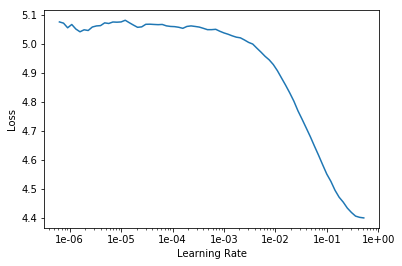

In [8]:
learn = language_model_learner(df,arch = AWD_LSTM, pretrained = True, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)

Now we see we have a learning plot that plots Loss over Learning Rate for the model. We want to choose the correct learning rate such that the "x-value" corresponds with the cusp of the curve, as described below: 

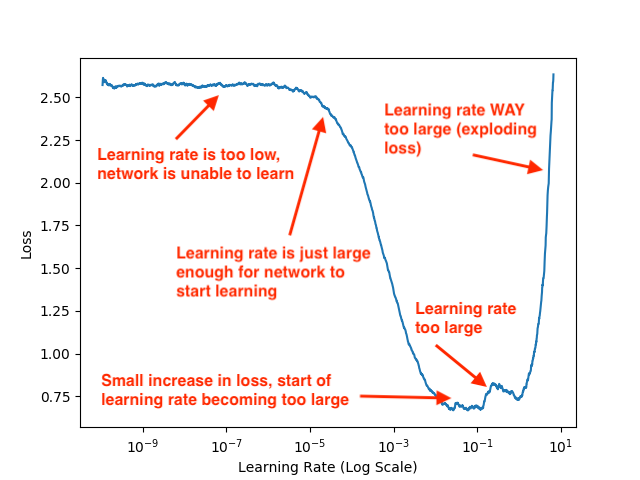

In our case, we choose 1e-2. 

In [9]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.784142,4.206024,0.279390,05:13
1,4.119358,3.282126,0.372619,05:33
2,3.541582,2.962264,0.398586,06:22
3,3.105903,2.841618,0.406622,06:16
4,2.787604,2.807056,0.412128,05:54
5,2.552684,2.792768,0.414807,05:39
6,2.371272,2.795833,0.413393,05:45
7,2.238400,2.788006,0.416518,05:43
8,2.141041,2.790372,0.416815,05:42
9,2.073323,2.791122,0.414658,05:50


In [10]:
learn.save('tweet_head')
learn.load('tweet_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2893 items)
x: LMTextList
xxbos xxmaj shoutout to my boy @stephenasmith and his new show on xxup xxunk xxmaj stephen a ’s xxmaj world ! xxmaj tonight ’s episode xxunk special guests xxmaj xxunk xxunk and my good friend xxmaj chris xxmaj rock .,xxbos xxmaj she is so smart , intelligent , charismatic , and funny , and i did n’t know that she xxunk with a speech xxunk . xxup must xxup see interview ! xxmaj please everyone check out her one - on - one with xxmaj anderson on xxup @cnn ! xxunk,xxbos i just witnessed one of the best interviews i ’ve ever seen on xxup tv ! ! xxup cnn ’s xxunk xxunk xxunk .,xxbos xxmaj the next group of xxup mvp candidates are xxmaj steph xxmaj curry , xxmaj kawhi xxmaj leonard , xxmaj anthony xxmaj davis , xxmaj luka xxmaj xxunk , xxmaj giannis xxmaj antetokounmpo and xxmaj bradley xxmaj xxunk .,xxbos lebron xxmaj james , xxmaj joel xxmaj embiid , xxmaj kevin xxmaj durant , xxmaj nikola xxmaj xxunk and x

Now after the initial training, we fine-tune the model using half of the epochs.

In [11]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.988812,2.794414,0.415774,05:46
1,1.990270,2.791414,0.416741,07:09
2,1.984840,2.794258,0.416964,06:33
3,1.972173,2.792512,0.416220,06:21
4,1.962185,2.796111,0.415253,06:29


In [103]:
learn.save('tweet_fine_tuned')
learn.load('tweet_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2893 items)
x: LMTextList
xxbos xxmaj shoutout to my boy @stephenasmith and his new show on xxup xxunk xxmaj stephen a ’s xxmaj world ! xxmaj tonight ’s episode xxunk special guests xxmaj xxunk xxunk and my good friend xxmaj chris xxmaj rock .,xxbos xxmaj she is so smart , intelligent , charismatic , and funny , and i did n’t know that she xxunk with a speech xxunk . xxup must xxup see interview ! xxmaj please everyone check out her one - on - one with xxmaj anderson on xxup @cnn ! xxunk,xxbos i just witnessed one of the best interviews i ’ve ever seen on xxup tv ! ! xxup cnn ’s xxunk xxunk xxunk .,xxbos xxmaj the next group of xxup mvp candidates are xxmaj steph xxmaj curry , xxmaj kawhi xxmaj leonard , xxmaj anthony xxmaj davis , xxmaj luka xxmaj xxunk , xxmaj giannis xxmaj antetokounmpo and xxmaj bradley xxmaj xxunk .,xxbos lebron xxmaj james , xxmaj joel xxmaj embiid , xxmaj kevin xxmaj durant , xxmaj nikola xxmaj xxunk and x

## Prediction

Now that we've trained our model, we're going to start outputting some tweets to feed to our bot. We first give the model a starter word or phrase to predict a subsequent ordering of words - all in the style of Magic Johnson. 

In [123]:
common_list = ["Lebron James", "Cookie", "The Lakers", "The Heat", "The Warriors", "The Raptors", "The", "My", "It is", 
              "President Trump", "A very", "The best", "One of the", "I am", "You have", "Here is", "Kawhi Leonard",
              "Giannis", "The NBA", "This is the", "I'm happy", "Both of the", 
               "I will", "OKC's", "Good luck", "Congratulations", "Hall of Fame", "If I", "To the", "The Cavs", "Spartan Nation", 
              "Laker Nation", "When will", "Now we see that", "I think that", "Going to the", "My favorite nautical exercise"]

def text(common_list):
    return random.choice(common_list)

N_WORDS = 18
N_SENTENCES = 1



In [124]:
print("\n".join(learn.predict(text(common_list) ,N_WORDS) for _ in range(N_SENTENCES)))

Hall of Fame School Board of White Members NBA to become a Michigan State


In [110]:
type(list)

str

In [ ]:

#output 1000 tweets to a file
with open('tweets.csv', mode='wb') as tweet_file:
    writer = csv.writer(tweet_file, delimiter = ',', encoding="utf-8")
    for i in range(1000):
        list = ("\n".join(learn.predict(text(common_list) ,N_WORDS) for _ in range(N_SENTENCES)))
        writer.writerow([list])
    